In [5]:
import os
import sys
import torch
import torch_geometric
from pathlib import Path
from model import GNNPolicy
from data_type import GraphDataset
from utils import process

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
problem = 'FCMCNF'
lr = 0.005
n_epoch = 5
patience = 10
early_stopping = 20
normalize = True
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_train = 1
batch_valid  = 256

loss_fn = torch.nn.BCELoss()
optimizer_fn = torch.optim.Adam

In [7]:
train_losses = []
valid_losses = []
train_accs = []
valid_accs = []

train_files = [ str(path) for path in Path(os.path.join(os.path.abspath(''), 
                                                        f"../node_selection/data/{problem}/train_cl")).glob("*.pt") ]

valid_files = [ str(path) for path in Path(os.path.join(os.path.abspath(''), 
                                                        f"../node_selection/data/{problem}/test_cl")).glob("*.pt") ]


train_files += train_files + valid_files[:3000]
valid_files = valid_files[3000:]

train_data = GraphDataset(train_files)
valid_data = GraphDataset(valid_files)

#inspect(train_data[:100])

# TO DO : learn something from the data
# train_loader = torch_geometric.loader.DataLoader(train_data, 
#                                                  batch_size=batch_train, 
#                                                  shuffle=True, 
#                                                  follow_batch=['constraint_features_s', 
#                                                                'constraint_features_t',
#                                                                'variable_features_s',
#                                                                'variable_features_t'])

# valid_loader = torch_geometric.loader.DataLoader(valid_data, 
#                                                  batch_size=batch_valid, 
#                                                  shuffle=False, 
#                                                  follow_batch=['constraint_features_s',
#                                                                'constraint_features_t',
#                                                                'variable_features_s',
#                                                                'variable_features_t'])
train_loader = torch_geometric.loader.DataLoader(train_data, 
                                            batch_size=batch_train, 
                                            shuffle=True, 
                                            follow_batch=['constraint_features_s', 
                                                        'constraint_features_t',
                                                        'constraint_features_root',
                                                        'variable_features_s',
                                                        'variable_features_t',
                                                        'variable_features_root'])

valid_loader = torch_geometric.loader.DataLoader(valid_data, 
                                                batch_size=batch_valid, 
                                                shuffle=False, 
                                                follow_batch=['constraint_features_s',
                                                            'constraint_features_t',
                                                            'constraint_features_root',
                                                            'variable_features_s',
                                                            'variable_features_t',
                                                            'variable_features_root'])

policy = GNNPolicy().to(device)
optimizer = optimizer_fn(policy.parameters(), lr=lr) #ADAM is the best

print("-------------------------")
print(f"GNN for problem {problem}")
print(f"Training on:          {len(train_data)} samples")
print(f"Validating on:        {len(valid_data)} samples")
print(f"Batch Size Train:     {batch_train}")
print(f"Batch Size Valid      {batch_valid}")
print(f"Learning rate:        {lr} ")
print(f"Number of epochs:     {n_epoch}")
print(f"Normalize:            {normalize}")
print(f"Device:               {device}")
print(f"Loss fct:             {loss_fn}")
print(f"Optimizer:            {optimizer_fn}")  
print(f"Model's Size:         {sum(p.numel() for p in policy.parameters())} parameters ")
print("-------------------------") 

-------------------------
GNN for problem FCMCNF
Training on:          41480 samples
Validating on:        132 samples
Batch Size Train:     1
Batch Size Valid      256
Learning rate:        0.005 
Number of epochs:     5
Normalize:            True
Device:               cuda
Loss fct:             BCELoss()
Optimizer:            <class 'torch.optim.adam.Adam'>
Model's Size:         26714 parameters 
-------------------------


In [8]:
for epoch in range(n_epoch):
    print(f"Epoch {epoch + 1}")

    train_loss, train_acc = process(policy, 
                                    train_loader, 
                                    loss_fn,
                                    device,
                                    optimizer=optimizer, 
                                    normalize=normalize,
                                    with_root_info = True)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    print(f"Train loss: {train_loss:0.3f}, accuracy {train_acc:0.3f}" )

    valid_loss, valid_acc = process(policy, 
                                    valid_loader, 
                                    loss_fn, 
                                    device,
                                    optimizer=None,
                                    normalize=normalize,
                                    with_root_info = True)
    valid_losses.append(valid_loss)
    valid_accs.append(valid_acc)

    print(f"Valid loss: {valid_loss:0.3f}, accuracy {valid_acc:0.3f}" )
torch.save(policy.state_dict(),f'policy_{problem}.pkl')

Epoch 1


Training Progress:   0%|          | 0/41480 [00:00<?, ?it/s]

Training Progress: 100%|██████████| 41480/41480 [29:03<00:00, 23.79it/s]


Train loss: 0.167, accuracy 0.948


Training Progress: 100%|██████████| 1/1 [00:00<00:00,  5.58it/s]


Valid loss: 0.179, accuracy 0.909
Epoch 2


Training Progress: 100%|██████████| 41480/41480 [29:38<00:00, 23.32it/s]


Train loss: 0.162, accuracy 0.949


Training Progress: 100%|██████████| 1/1 [00:00<00:00,  5.69it/s]


Valid loss: 0.178, accuracy 0.924
Epoch 3


Training Progress: 100%|██████████| 41480/41480 [29:37<00:00, 23.33it/s]


Train loss: 0.161, accuracy 0.950


Training Progress: 100%|██████████| 1/1 [00:00<00:00,  5.60it/s]


Valid loss: 0.182, accuracy 0.909
Epoch 4


Training Progress: 100%|██████████| 41480/41480 [29:36<00:00, 23.35it/s]


Train loss: 0.161, accuracy 0.949


Training Progress: 100%|██████████| 1/1 [00:00<00:00,  5.62it/s]


Valid loss: 0.180, accuracy 0.917
Epoch 5


Training Progress: 100%|██████████| 41480/41480 [29:39<00:00, 23.31it/s]


Train loss: 0.161, accuracy 0.951


Training Progress: 100%|██████████| 1/1 [00:00<00:00,  5.60it/s]

Valid loss: 0.177, accuracy 0.932


In [9]:
torch.save(policy.state_dict(),f'policy_{problem}.pkl')

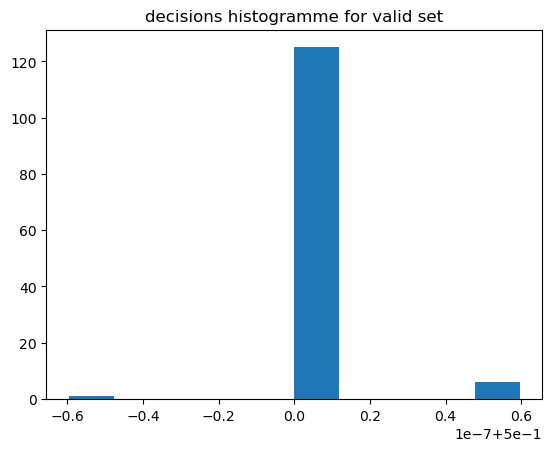

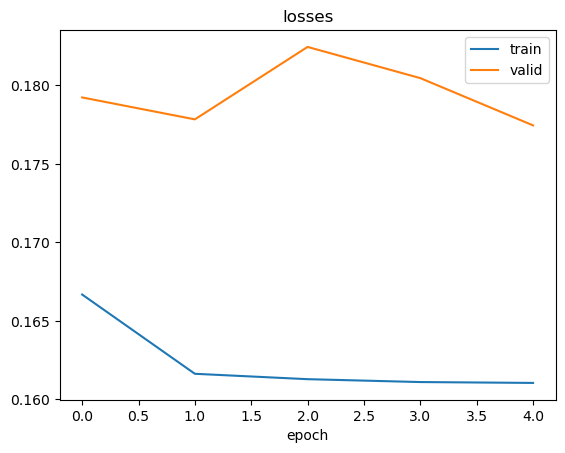

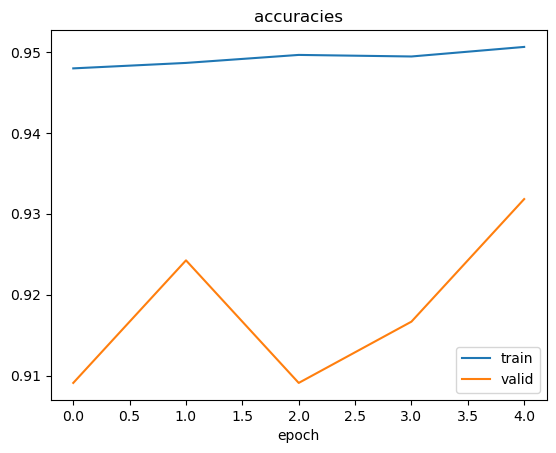

: 

In [10]:
decisions = [ policy(dvalid.to(device)).item() for dvalid in valid_data ]

import matplotlib.pyplot as plt
plt.figure(0)
plt.hist(decisions)
plt.title('decisions histogramme for valid set')
plt.savefig("./hist.png")

plt.figure(1)
plt.plot(train_losses, label='train')
plt.plot(valid_losses, label='valid')
plt.title('losses')
plt.xlabel('epoch')
plt.legend()
plt.savefig("./losses.png")


plt.figure(2)
plt.plot(train_accs, label='train')
plt.plot(valid_accs, label='valid')
plt.title('accuracies')
plt.xlabel('epoch')
plt.legend()
plt.savefig("./accuracies.png")

